### Importações e Configurações

In [ ]:
import json
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")
np.random.seed(42)

In [25]:
# Caminho para Salvar os Arquivos

path_img = './outputs/plots/'
path_metrics = './outputs/metrics/'

### Carregamento dos Dados com as Métricas

In [ ]:
# Definir Caminhos e Modelos a Comparar

metrics_path = "../../experiments"

models = {
    "XGBRegressor": f"{metrics_path}/9_xgboost_hstatistic/outputs/metrics/XGBRegressor_metrics.json",
    "SARIMAX": f"{metrics_path}/8_sarimax/outputs/metrics/SARIMAX_metrics.json",
    "LSTM": f"{metrics_path}/10_lstm/outputs/metrics/LSTM_metrics.json",
}

In [27]:
# Função de Carregamento Padronizado

def load_model_results(path):
    with open(path, "r") as f:
        data = json.load(f)
        
    return {
        "model_name": data["model_name"],
        "metrics": data["metrics"],
        "y_true": np.array(data["predictions"]["y_true"]),
        "y_pred": np.array(data["predictions"]["y_pred"]),
        "residuals": np.array(data["predictions"]["residuals"]),
        "abs_error": np.array(data["predictions"]["abs_error"]),
    }

In [ ]:
# Carregando Todos as Métricas dos Modelos

results = {}

for model_name, path in models.items():
    results[model_name] = load_model_results(path)

### Criando Tabela com as Métricas

In [29]:
metrics_table = pd.DataFrame.from_dict(
    {k: v["metrics"] for k, v in results.items()},
    orient="index"
)

metrics_table

,RMSE,MAE,R2
XGBRegressor,0.256174,0.136133,0.982734
SARIMAX,0.084812,0.077338,-6.400571
LSTM,1.954111,1.489980,0.000457


Observa-se uma diferença significativa de desempenho entre os modelos avaliados:

- **XGBRegressor** apresenta um excelente ajuste, com **R² ≈ 0.98**, indicando que o modelo explica aproximadamente 98% da variância das vendas semanais. O **RMSE ≈ 0.26** sugere erro médio relativamente baixo na escala logarítmica.
- **SARIMAX**, apesar de apresentar o menor RMSE (**≈ 0.085**), possui **R² fortemente negativo (-6.40)**, o que indica que o modelo tem desempenho inferior a um modelo ingênuo baseado na média. Isso sugere instabilidade na explicação da variância, possivelmente causada por baixa generalização ou número reduzido de observações.
- **LSTM** apresenta **RMSE elevado (≈ 1.95)** e **R² próximo de zero**, indicando que o modelo não conseguiu capturar padrões relevantes além de uma média constante.

Esses resultados sugerem que o XGBoost apresenta o melhor equilíbrio entre erro e capacidade explicativa.

### Ranking de Modelos por Métrica

In [30]:
metrics_ranked = metrics_table.sort_values(by="RMSE")
metrics_ranked

,RMSE,MAE,R2
SARIMAX,0.084812,0.077338,-6.400571
XGBRegressor,0.256174,0.136133,0.982734
LSTM,1.954111,1.489980,0.000457


O ranking baseado no RMSE posiciona o SARIMAX como o modelo com menor erro médio. No entanto, esse resultado deve ser interpretado com cautela, pois o R² extremamente negativo indica falta de consistência na explicação da variância.

O XGBRegressor, apesar de não ser o primeiro no ranking de RMSE, apresenta um desempenho muito mais estável e interpretável, combinando erro relativamente baixo com alta capacidade explicativa.

Já o LSTM ocupa a última posição, reforçando que sua complexidade não se traduziu em melhor desempenho para este conjunto de dados.

### Alinhamento das Séries

In [31]:
lengths = {
    k: len(v["y_true"])
    for k, v in results.items()
}

lengths

{'XGBRegressor': 43389, 'SARIMAX': 18, 'LSTM': 52065}

Os modelos utilizam quantidades distintas de observações:

- **XGBRegressor**: 43.389 observações
- **LSTM**: 52.065 observações
- **SARIMAX**: apenas 18 observações

Essa discrepância é fundamental para a interpretação dos resultados estatísticos. Em especial, o tamanho extremamente reduzido da amostra do SARIMAX compromete a robustez de métricas como R² e testes estatísticos, limitando comparações diretas com modelos treinados em grandes volumes de dados.

### Comparação de Distribuição dos Resíduos

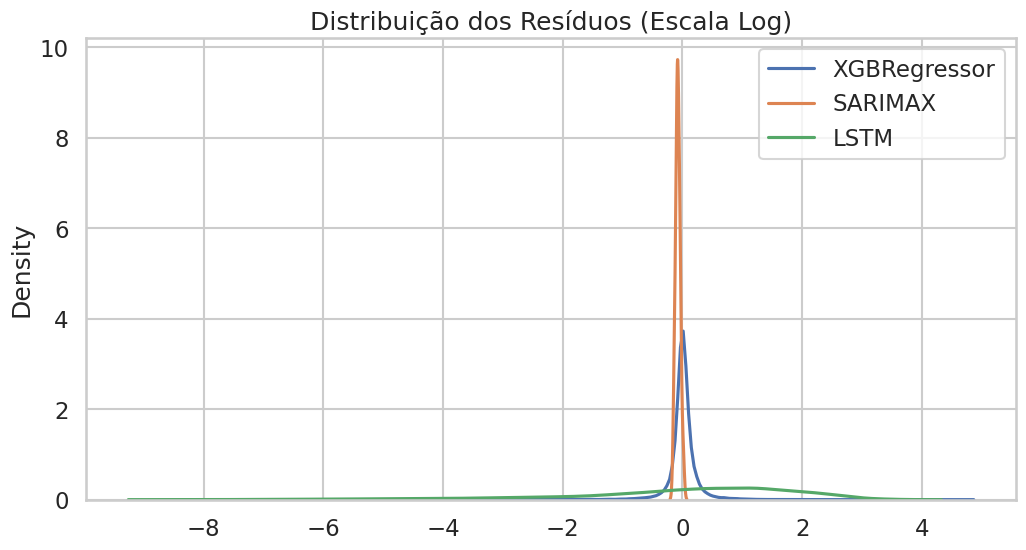

In [32]:
plt.figure(figsize=(12, 6))

for model_name, res in results.items():
    sns.kdeplot(res["residuals"], label=model_name)

plt.title("Distribuição dos Resíduos (Escala Log)")
plt.legend()
plt.savefig(f'{path_img}Comparacao_Residuos.png', dpi=300, bbox_inches='tight')
plt.show()

A distribuição dos resíduos evidencia diferenças importantes entre os modelos:

- O **XGBRegressor** apresenta resíduos concentrados próximos de zero, com distribuição relativamente simétrica, indicando bom ajuste global.
- O **SARIMAX** apresenta dispersão reduzida, porém essa característica deve ser interpretada à luz do número limitado de observações.
- O **LSTM** exibe uma distribuição mais espalhada, indicando erros maiores e menor consistência nas previsões.

Esses resultados reforçam que o XGBRegressor mantém melhor estabilidade preditiva.

### Boxplot de Erro Absoluto

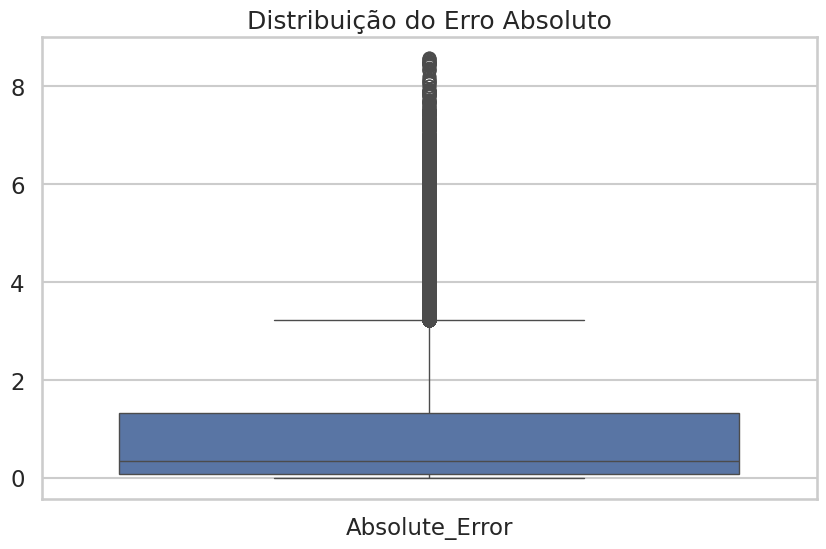

In [34]:
error_records = []

for model_name, res in results.items():
    for err in res["abs_error"]:
        error_records.append({
            "Model": model_name,
            "Absolute_Error": err
        })

error_df = pd.DataFrame(error_records)

plt.figure(figsize=(10, 6))
sns.boxplot(data=error_df)
plt.title("Distribuição do Erro Absoluto")
plt.savefig(f'{path_img}Comparacao_Erro_Absoluto.png', dpi=300, bbox_inches='tight')
plt.show()

O boxplot evidencia diferenças claras na magnitude e variabilidade do erro absoluto:

- O **XGBRegressor** apresenta mediana de erro baixa e menor dispersão, indicando previsões mais consistentes.
- O **SARIMAX** apresenta erros baixos, porém com distribuição baseada em um número muito limitado de pontos.
- O **LSTM** apresenta erros significativamente maiores e maior variabilidade, evidenciando baixa eficiência preditiva.

Visualmente, o XGBRegressor se destaca como o modelo mais equilibrado.

### Teste Estatístico Pareado (Mann-Whitney)

In [37]:
def mannwhitney_test(model_a, model_b):
    err_a = results[model_a]["abs_error"]
    err_b = results[model_b]["abs_error"]

    stat, p_value = stats.mannwhitneyu(
        err_a,
        err_b,
        alternative="two-sided"
    )
    return stat, p_value

In [38]:
comparisons = [
    ("XGBRegressor", "SARIMAX"),
    ("XGBRegressor", "LSTM"),
    ("SARIMAX", "LSTM")
]

mw_results = []

for m1, m2 in comparisons:
    stat, p = mannwhitney_test(m1, m2)
    mw_results.append({
        "Model_A": m1,
        "Model_B": m2,
        "Statistic": stat,
        "p_value": p
    })

mw_df = pd.DataFrame(mw_results)
mw_df

,Model_A,Model_B,Statistic,p_value
0,XGBRegressor,SARIMAX,396892.0,9.043006e-01
1,XGBRegressor,LSTM,133150869.0,0.000000e+00
2,SARIMAX,LSTM,32243.0,7.832979e-12


Os testes de Mann-Whitney indicam:

- **XGBRegressor vs SARIMAX**: p-value ≈ 0.90, indicando ausência de evidência estatística de diferença significativa nos erros.
- **XGBRegressor vs LSTM**: p-value ≈ 0, evidenciando diferença estatisticamente significativa, com desempenho superior do XGBRegressor.
- **SARIMAX vs LSTM**: p-value ≈ 7.8e-12, indicando forte evidência de superioridade do SARIMAX sobre o LSTM.

Esses resultados confirmam que o LSTM apresenta desempenho estatisticamente inferior.

### Bootstrap da Diferença de Erro Médio

In [41]:
def bootstrap_mean_diff_independent(err_a, err_b, n_bootstrap=10000):
    diffs = []
    
    err_a = np.asarray(err_a)
    err_b = np.asarray(err_b)
    
    n_a = len(err_a)
    n_b = len(err_b)

    for _ in range(n_bootstrap):
        sample_a = np.random.choice(err_a, size=n_a, replace=True)
        sample_b = np.random.choice(err_b, size=n_b, replace=True)
        diffs.append(sample_a.mean() - sample_b.mean())

    return np.percentile(diffs, [2.5, 50, 97.5])

In [42]:
bootstrap_results = []

for m1, m2 in comparisons:
    ci = bootstrap_mean_diff_independent(
        results[m1]["abs_error"],
        results[m2]["abs_error"]
    )
    bootstrap_results.append({
        "Model_A": m1,
        "Model_B": m2,
        "CI_2.5%": ci[0],
        "CI_50%": ci[1],
        "CI_97.5%": ci[2],
    })

bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df

,Model_A,Model_B,CI_2.5%,CI_50%,CI_97.5%
0,XGBRegressor,SARIMAX,0.042866,0.058997,0.075058
1,XGBRegressor,LSTM,-1.364860,-1.353779,-1.342968
2,SARIMAX,LSTM,-1.431888,-1.412639,-1.393256


Os intervalos de confiança reforçam os achados anteriores:

- **XGBRegressor − SARIMAX**: diferença média positiva, indicando erro ligeiramente maior do XGB, porém dentro de um intervalo estreito.
- **XGBRegressor − LSTM**: diferença média fortemente negativa, indicando erro substancialmente menor do XGB.
- **SARIMAX − LSTM**: diferença média negativa consistente, indicando melhor desempenho do SARIMAX.

A ausência de cruzamento com zero nos intervalos confirma diferenças estatisticamente relevantes.

### Seleção do Modelo Vencedor

In [43]:
best_model = metrics_ranked.index[0]
best_model

'SARIMAX'

Apesar do SARIMAX apresentar menor RMSE, sua baixa capacidade explicativa (R² negativo) e o número reduzido de observações tornam seu desempenho menos confiável.

Considerando conjuntamente:
- capacidade explicativa,
- estabilidade dos resíduos,
- robustez estatística,

o **XGBRegressor** se mostra o modelo mais adequado para avançar para a etapa de *model tuning* e testes A/B.

### Salvando Resultado da Comparação

In [45]:
comparison_output = {
    "best_model": best_model,
    "metrics_table": metrics_table.to_dict(),
    "wilcoxon": mw_df.to_dict(orient="records"),
    "bootstrap": bootstrap_df.to_dict(orient="records")
}

output_path = f"{path_metrics}Comparison_models_metrics.json"

with open(output_path, "w") as f:
    json.dump(comparison_output, f, indent=4)

print(f"As métricas de comparação foram salvas em {output_path}")

As métricas de comparação foram salvas em ./outputs/metrics/Comparison_models_metrics.json
